# https://www.bogleheads.org/forum/viewtopic.php?p=4837326#p4837326

In [1]:
%matplotlib inline
import plot
import market
import metrics
from decimal import Decimal
import pandas
import simulate
import withdrawal
import harvesting
import seaborn
import math

In [2]:
class am_bogleheads(withdrawal.WithdrawalStrategy):
    def __init__(self, portfolio, harvest):
        super().__init__(portfolio, harvest)
        self.floor = self.portfolio.value * Decimal('0.03')

    def start(self):
        return self.portfolio.value * Decimal('.05')

    def next(self):
        adjusted_floor = self.floor * self.portfolio.inflation
        return max(adjusted_floor, self.portfolio.value * Decimal('.05'))


In [3]:
series = market.Returns_US_1871()

In [11]:
TYPE = 'Withdrawal (Real)'
m = {'Withdrawal (Nominal)': lambda x: float(x.withdraw_n),
     'Withdrawal (Real)' : lambda x: float(x.withdraw_r),
     'Portfolio (Nominal)': lambda x: float(x.portfolio_n),
     'Portfolio (Real)': lambda x: float(x.portfolio_r),
     'Withdrawal Percent': lambda x: float(x.withdraw_pct_cur)
}
lens = m[TYPE]
lens.__label__ = TYPE

def fn(x):
    return [lens(_) for _ in x]


In [41]:
year = 1966

w = {
    'vpw': lambda p,h: withdrawal.VPW(p, h, years_left=45),
    'am': am_bogleheads,
    '5%': withdrawal.ConstantPercentage,
}

def run_sim(year, key, length=15):
    portfolio = (600_000, 400_000)
    harvest_strategy = harvesting.make_rebalancer(0.6)
    
    return simulate.withdrawals(series.iter_from(year),
                                 withdraw=w[key],
                                 years=length,
                                 portfolio=portfolio,
                                 harvesting=harvest_strategy)


In [42]:
def blanchett_smile(age, target=40_000):
    """ This returns the real annual change in consumption at a given age.
    From Blanchett's "Estimating the True Cost of Retirement" (2013)
    """
    spend = (0.00008 * age * age) - (0.0125 * age) - (0.0066 * math.log(target)) + 0.546
    return spend

def spending():
    s = []
    spend = 80_000
    for i in range(65,95):
        delta = blanchett_smile(i, target=80_000)
        spend *= (1 + delta)
        s.append(spend)
    return s

Text(0.5, 0.98, 'Retirement in 1966')

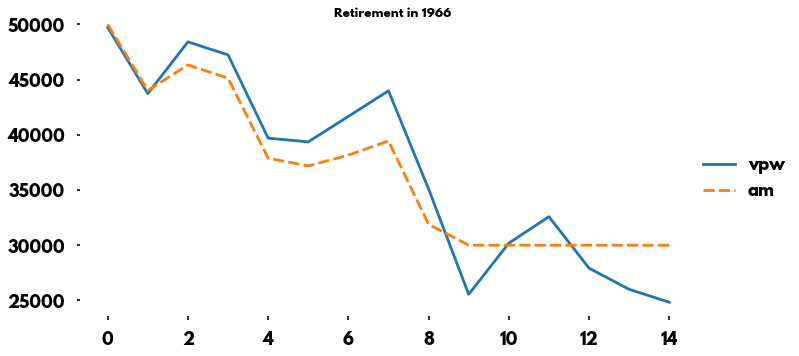

In [43]:
df = pandas.DataFrame({
    'vpw' : [lens(x) for x in run_sim(year, 'vpw')],
    'am' : [lens(x) for x in run_sim(year, 'am')],
#    'spending' : spending(),
})
g = seaborn.relplot(
        data=df,
        kind='line',
        aspect=2,
    )
#g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle(f'Retirement in {year}')

In [44]:
df[df['am'] > df['vpw']]

,vpw,am
0,49709.000000,50000.000000
1,43728.382979,44005.622918
9,25550.289017,29999.997456
12,27921.014492,30000.002221
13,26006.481535,29999.997872
14,24840.485006,29999.999764


In [45]:
a = df[df['am'] > df['vpw']]

In [46]:
a['am'] / a['vpw']

0     1.005854
1     1.006340
9     1.174155
12    1.074460
13    1.153559
14    1.207706
dtype: float64

In [47]:
all_s = {}
for strategy in ['vpw', 'am']:
    s = pandas.Series()
    for year in range(1871, 2018-15):
        withdraws = fn(run_sim(year, strategy))
        new_s = pandas.Series(withdraws)
        s = s.append(new_s, ignore_index=True)
    all_s[strategy] = s
df = pandas.DataFrame(all_s)
df.head()

,vpw,am
0,49709.000000,50000.000000
1,52488.480734,51431.688359
2,53112.718261,51526.339423
3,53511.568961,52027.427314
4,59350.346329,56559.927328


In [48]:
df.mean()

vpw    57801.382179
am     52432.172251
dtype: float64

In [49]:
df.median()

vpw    54055.732241
am     50013.696977
dtype: float64

In [54]:
metrics.cew([Decimal(d) for d in df['vpw']])

Decimal('45241.84942276598972759580077')

In [55]:
metrics.cew([Decimal(d) for d in df['am']])

Decimal('43457.98234438251419004841485')